# Compute transition numbers for green, brown and neutral occupations
Felix Zaussinger | 20.08.2021, adapted on 27.10.2021

## Adaptations
- wage continuity constraint at 90 %

In [97]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(context="paper", font_scale=1.1)
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [98]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [99]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [100]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

In [101]:
# nesta report matrix
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined_no_military.npy")
)

np.fill_diagonal(sim_kanders, 0)

## Determine closest matches based on skill similiarity

In [102]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

## Iterate over all occupations and identify transition options

In [103]:
# thresholds
VIABLE = 0.3
HIGHLY_VIABLE = 0.4
EARNINGS_RATIO = 0.9
JOB_ZONE_DELTA = 1

In [104]:
transition_numbers_all = {}
df_occ = pd.DataFrame(df_metadata.concept_uri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in tqdm(df_metadata.index.values):

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.iloc[i, :]
    #print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "annual_earnings",
            "is_brown",
            "is_green",
            "is_neutral",
            "job_zone"
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add transitions metadata
    result["job_zone_delta"] = np.abs(source_occ.job_zone - result.job_zone)
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings

    result["is_viable"] = (result.similarity >= VIABLE) & (result.job_zone_delta <= JOB_ZONE_DELTA)
    result["is_highly_viable"] = (result.similarity >= HIGHLY_VIABLE)  & (result.job_zone_delta <= JOB_ZONE_DELTA)
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= EARNINGS_RATIO)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= EARNINGS_RATIO)
    #result["is_green"] = result.greenness_vona_2018_v2 > 0
    #result["is_neutral"] = (result.greenness_vona_2018_v2 == 0) & (result.is_brown == False)

    # viable transitions by gbn
    result["is_viable_brown"] = result.is_viable & (result.is_brown == True)
    result["is_viable_neutral"] = result.is_viable & (result.is_neutral == True)
    result["is_viable_green"] = result.is_viable & (result.is_green == True)

    # highly viable transitions by gbn
    result["is_highly_viable_brown"] = result.is_highly_viable & (result.is_brown == True)
    result["is_highly_viable_neutral"] = result.is_highly_viable & (result.is_neutral == True)
    result["is_highly_viable_green"] = result.is_highly_viable & (result.is_green == True)

    # desirable transitions by gbn
    result["is_desirable_brown"] = result.is_desirable & (result.is_brown == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions by gbn
    result["is_highly_desirable_brown"] = result.is_highly_desirable & (result.is_brown == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_viable_brown', 'is_viable_neutral', 'is_viable_green',
        'is_highly_viable_brown', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_brown', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_brown', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers_all[i] = s_sum

100%|██████████| 2921/2921 [00:57<00:00, 50.38it/s]


In [105]:
# to df
cols_merge = ["preferred_label", "isco_level_1"] #, "annual_earnings", "education_level", "related_work_experience", "on_the_job_training"]
df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled = pd.concat(
    [df_metadata[cols_merge], df_transition_numbers_all], axis=1
)

In [106]:
# boxplots of transition numbers by isco lvl 1 groups
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

#### How do the transition numbers vary between green, neutral and brown occupations?

In [107]:
# merge transition numbers to all the other metadata, export csv
df_metadata_transitions = pd.concat(
    [df_metadata, df_transition_numbers_all], axis=1
)

df_metadata_transitions2 = df_metadata_transitions.copy()
df_metadata_transitions2["occ_type"] = df_metadata_transitions2[["is_brown", "is_neutral", "is_green"]].idxmax(axis=1)

In [108]:
df_metadata_transitions2_long = df_metadata_transitions2.melt(
    id_vars=["occ_type"],
    value_vars=["is_viable", "is_desirable", "is_highly_viable", "is_highly_desirable"],
    value_name="transitions",
    var_name="transition_category"
)

In [109]:
replace_dict = {
    "target": {"is_viable_neutral": "neutral", "is_viable_green": "green", "is_viable_brown": "brown"},
    "occ_type": {"is_neutral": "neutral", "is_green": "green", "is_brown": "brown"}
}

#### Let's concentrate on the actual research question: the transition possibilities of brown occupations

- don't cover transitions out of neutral or green occupations
- focus exclusively on transitions out of brown occupations and look at it more granularly

In [110]:
# store mean values of transition numbers per category
transition_cats = ["is_viable", "is_desirable", "is_highly_viable", "is_highly_desirable"]

transition_cat_means = {}
transition_cat_medians = {}

for cat in transition_cats:
    transition_cat_means[cat] = df_metadata_transitions2[cat].mean()
    transition_cat_medians[cat] = df_metadata_transitions2[cat].median()

In [111]:
# subset brown occupatins
df_metadata_transitions2_brown = df_metadata_transitions2.query("occ_type == 'is_brown'")

In [112]:
list_of_value_vars = [
    ["is_viable_brown", "is_viable_neutral", "is_viable_green"],
    ["is_highly_viable_brown", "is_highly_viable_neutral", "is_highly_viable_green"],
    ["is_desirable_brown", "is_desirable_neutral", "is_desirable_green"],
    ["is_highly_desirable_brown", "is_highly_desirable_neutral", "is_highly_desirable_green"],
]

list_of_df_categories = []

for i, value_vars in enumerate(list_of_value_vars):
    df_categories = df_metadata_transitions2_brown.melt(
        value_vars=value_vars,
        value_name="transitions",
        var_name="target",
        id_vars="isco_level_1"
    )

    ids = pd.DataFrame(np.column_stack(list(zip(*df_categories.target.str.split("_")))))

    if (i % 2) == 0:
        df_categories["category"] = ids.iloc[:, 1]
        df_categories["target"] = ids.iloc[:, 2]
    else:
        df_categories["category"] = ids.iloc[:, 1] + "_" + ids.iloc[:, 2]
        df_categories["target"] = ids.iloc[:, 3]

    list_of_df_categories.append(df_categories)

df_categories_long = pd.concat(list_of_df_categories).reset_index(drop=True)
df_categories_long["category"] = pd.Categorical(df_categories_long["category"], ["viable", "desirable", "highly_viable", "highly_desirable"])

In [113]:
# used in the text to discuss percentage differences in transition numbers
transition_cat_means_num = {
    'is_viable': 100.90345771995892,
    'is_desirable': 87.37247517973297,
    'is_highly_viable': 32.82505991098939,
    'is_highly_desirable': 29.31941116056145
}

delta_mean = df_categories_long.groupby(["category", "target"]).mean().reset_index().set_index("category").join(
    pd.DataFrame(transition_cat_means_num, index=["category"]).T,
    how="left",
)

delta_mean["delta"] = delta_mean.transitions - delta_mean.category / 3
delta_mean["ratio"] = (delta_mean.transitions / (delta_mean.category / 3)) - 1

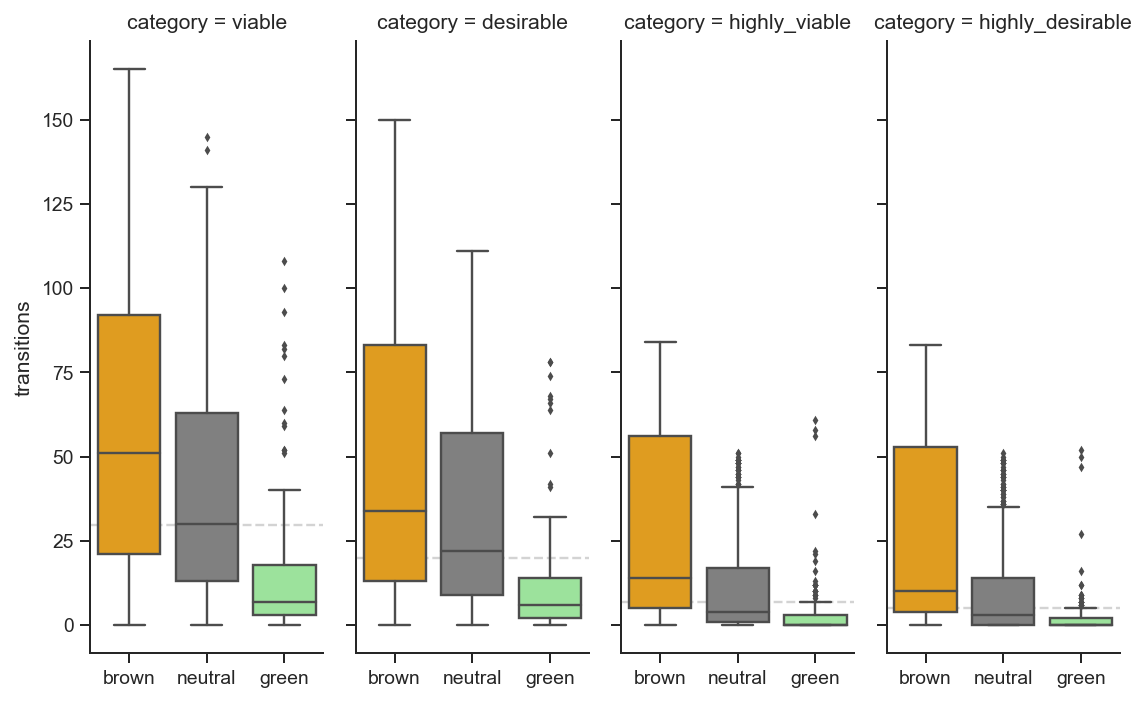

In [114]:
c = sns.catplot(
    y="transitions",
    x="target",
    col="category",
    #col_wrap=1,
    kind="box",
    order=["brown", "neutral", "green"],
    palette=["orange", "grey", "lightgreen"],
    sharex=False,
    height=5,
    aspect=0.4,
    fliersize=2,
    data=df_categories_long
)

for cat, ax in zip(transition_cats, c.axes[0]):
    #ax.set_ylim(0)
    ax.set_xlabel(None)

    ax.axhline(
    transition_cat_medians[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ4", "n_transitions_source_brown_only_boxplot_wage_{}.png".format(int(EARNINGS_RATIO * 100))),
    dpi=300,
    bbox_inches="tight"
)


#### Slight adaptations

- boxplot for viable (g+b+n) vs desirable (g+b+n)
- another boxplot that splits desirable into g and n

54.0
23.0
16.0
5.0


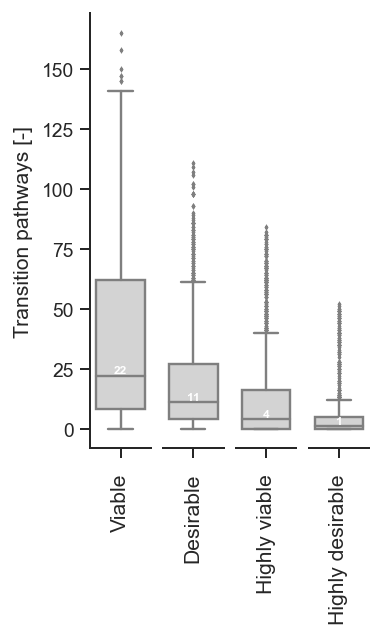

In [115]:
# annotations
vertical_offset = 1
size = 6

with sns.plotting_context("paper", font_scale=1.1):

    # figure
    fig, axes = plt.subplots(ncols=4, sharey=True, figsize=(2.5, 4))

    # viable
    data = df_categories_long.query("category == 'viable'")
    median = data.transitions.median()
    print(data.transitions.quantile(0.75) - data.transitions.quantile(0.25))

    sns.boxplot(y="transitions", ax=axes[0], color="lightgrey", fliersize=1, data = data)
    axes[0].set_xlabel("Viable", rotation=90)
    axes[0].set_ylabel("Transition pathways [-]")
    axes[0].text(0, median + vertical_offset, "{:.0f}".format(median), horizontalalignment='center', size=size, color='w', weight='semibold')

    # desirable
    data = df_categories_long.query("(category == 'desirable') and (target == 'green' or target == 'neutral')")
    median = data.transitions.median()
    print(data.transitions.quantile(0.75) - data.transitions.quantile(0.25))

    sns.boxplot(y="transitions", ax=axes[1], color="lightgrey", fliersize=1, data = data)
    axes[1].set_xlabel("Desirable", rotation=90)
    axes[1].set_ylabel(None)
    axes[1].text(0, median + vertical_offset, "{:.0f}".format(median), horizontalalignment='center', size=size, color='w', weight='semibold')

    # highly viable
    data = df_categories_long.query("category == 'highly_viable'")
    median = data.transitions.median()
    print(data.transitions.quantile(0.75) - data.transitions.quantile(0.25))

    sns.boxplot(y="transitions", ax=axes[2], color="lightgrey", fliersize=1, data = data)
    axes[2].set_xlabel("Highly viable", rotation=90)
    axes[2].set_ylabel(None)
    axes[2].text(0, median + vertical_offset, "{:.0f}".format(median), horizontalalignment='center', size=size, color='w', weight='semibold')

    # highly desirable
    data = df_categories_long.query("(category == 'highly_desirable') and (target == 'green' or target == 'neutral')")
    median = data.transitions.median()
    print(data.transitions.quantile(0.75) - data.transitions.quantile(0.25))

    sns.boxplot(y="transitions", ax=axes[3], color="lightgrey", fliersize=1, data = data)
    axes[3].set_xlabel("Highly desirable", rotation=90)
    axes[3].set_ylabel(None)
    axes[3].text(0, median + vertical_offset, "{:.0f}".format(median), horizontalalignment='center', size=size, color='w', weight='semibold')

    # style
    sns.despine()

    # remove axis
    axes[1].spines['left'].set_visible(False)
    axes[2].spines['left'].set_visible(False)
    axes[3].spines['left'].set_visible(False)

    # remove axis labels
    axes[1].axes.get_yaxis().set_visible(False)
    axes[2].axes.get_yaxis().set_visible(False)
    axes[3].axes.get_yaxis().set_visible(False)

    plt.savefig(
        os.path.join(figure_dir, "RQ4", "n_transitions_by_category_wage_{}.png".format(int(EARNINGS_RATIO * 100))),
        dpi=300,
        bbox_inches="tight"
    )


        transitions    
             median iqr
target                 
green             6  12
neutral          22  48
        transitions    
             median iqr
target                 
green             0   2
neutral           3  14


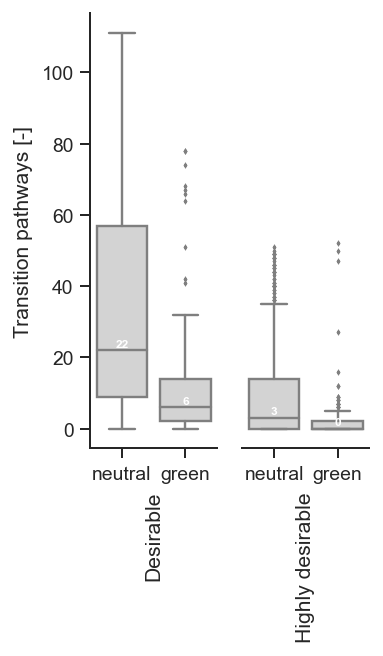

In [116]:
# annotations
vertical_offset = 1
size = 6

with sns.plotting_context("paper", font_scale=1.1):

    # figure
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(2.5, 4))

    # desirable
    data = df_categories_long.query("(category == 'desirable') and (target == 'green' or target == 'neutral')")
    stats = data.groupby("target").aggregate({"transitions": [np.median, scipy.stats.iqr]})
    medians = stats.loc[:, (slice(None), 'median')].values.flatten()[::-1]
    print(stats)

    sns.boxplot(x="target", y="transitions", ax=axes[0], color="lightgrey", fliersize=1, data = data)
    axes[0].set_xlabel("Desirable", rotation=90)
    axes[0].set_ylabel("Transition pathways [-]")

    for ax in axes[0].get_xticks():
        axes[0].text(ax, medians[ax] + vertical_offset, "{:.0f}".format(medians[ax]), horizontalalignment='center', size=size, color='w', weight='semibold')

    # highly desirable
    data = df_categories_long.query("(category == 'highly_desirable') and (target == 'green' or target == 'neutral')")
    stats = data.groupby("target").aggregate({"transitions": [np.median, scipy.stats.iqr]})
    medians = stats.loc[:, (slice(None), 'median')].values.flatten()[::-1]
    print(stats)

    sns.boxplot(x="target", y="transitions", ax=axes[1], color="lightgrey", fliersize=1, data = data)
    axes[1].set_xlabel("Highly desirable", rotation=90)
    axes[1].set_ylabel(None)

    for ax in axes[1].get_xticks():
        axes[1].text(ax, medians[ax] + vertical_offset, "{:.0f}".format(medians[ax]), horizontalalignment='center', size=size, color='w', weight='semibold')

    # style
    sns.despine()

    # remove axis
    axes[1].spines['left'].set_visible(False)

    # remove axis labels
    axes[1].axes.get_yaxis().set_visible(False)

    plt.savefig(
        os.path.join(figure_dir, "RQ4", "n_transitions_desirable_by_target_wage_{}.png".format(int(EARNINGS_RATIO * 100))),
        dpi=300,
        bbox_inches="tight"
    )

#### group barplots by isco-08 1-digit level

In [117]:
new_labels = []
for entry in list(isco_lvl1_mapping.items()):
    code, label = entry
    new_label = str(code) + ": " + label
    new_labels.append(new_label)

new_labels_short = new_labels[0:4] + new_labels[6:9]

In [118]:
# subset step 1: drop empty isco levels
data = df_categories_long.query("(isco_level_1 != 5) & (isco_level_1 != 6)").replace({"isco_level_1": dict(zip(np.arange(1, 10), new_labels))}).sort_values("isco_level_1")

# subset step 2: restrict to desirability dimension and green/neutral targets
data = data.query("(category == 'desirable' or category == 'highly_desirable') and (target != 'brown')")

# drop unused levels
data.category = data.category.cat.remove_unused_categories()

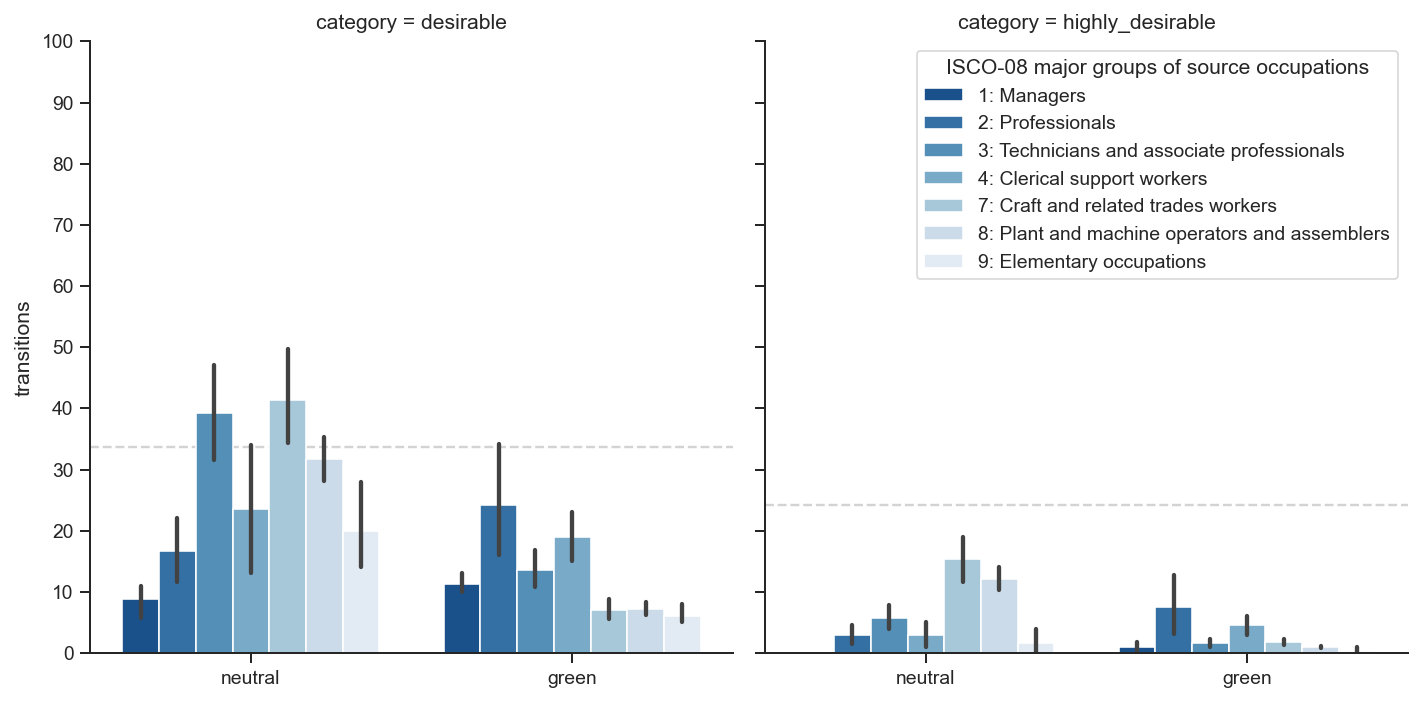

In [119]:
c = sns.catplot(
    y="transitions",
    x="target",
    hue="isco_level_1",
    col="category",
    col_wrap=2,
    kind="bar",
    order=["neutral", "green"],
    hue_order=new_labels_short,
    palette="Blues_r",
    #ci=95,
    #capsize=0.05,
    #errwidth=1,
    sharex=False,
    height=5,
    aspect=1,
    legend=False,
    data=data
)

for cat, ax in zip(transition_cats, c.axes):
    #ax.set_ylim(0)
    ax.set_xlabel(None)
    ax.set_yticks(np.arange(0, 110, 10))

    ax.axhline(
    transition_cat_means[cat] / 3,
    linestyle="--",
    color="lightgrey",
    zorder=0
)

plt.tight_layout()
plt.legend(loc="best", title="ISCO-08 major groups of source occupations")

# plt.savefig(
#     os.path.join(figure_dir, "RQ4", "n_transitions_source_brown_only_by_isco1.png"),
#     dpi=300,
#     bbox_inches="tight"
# )

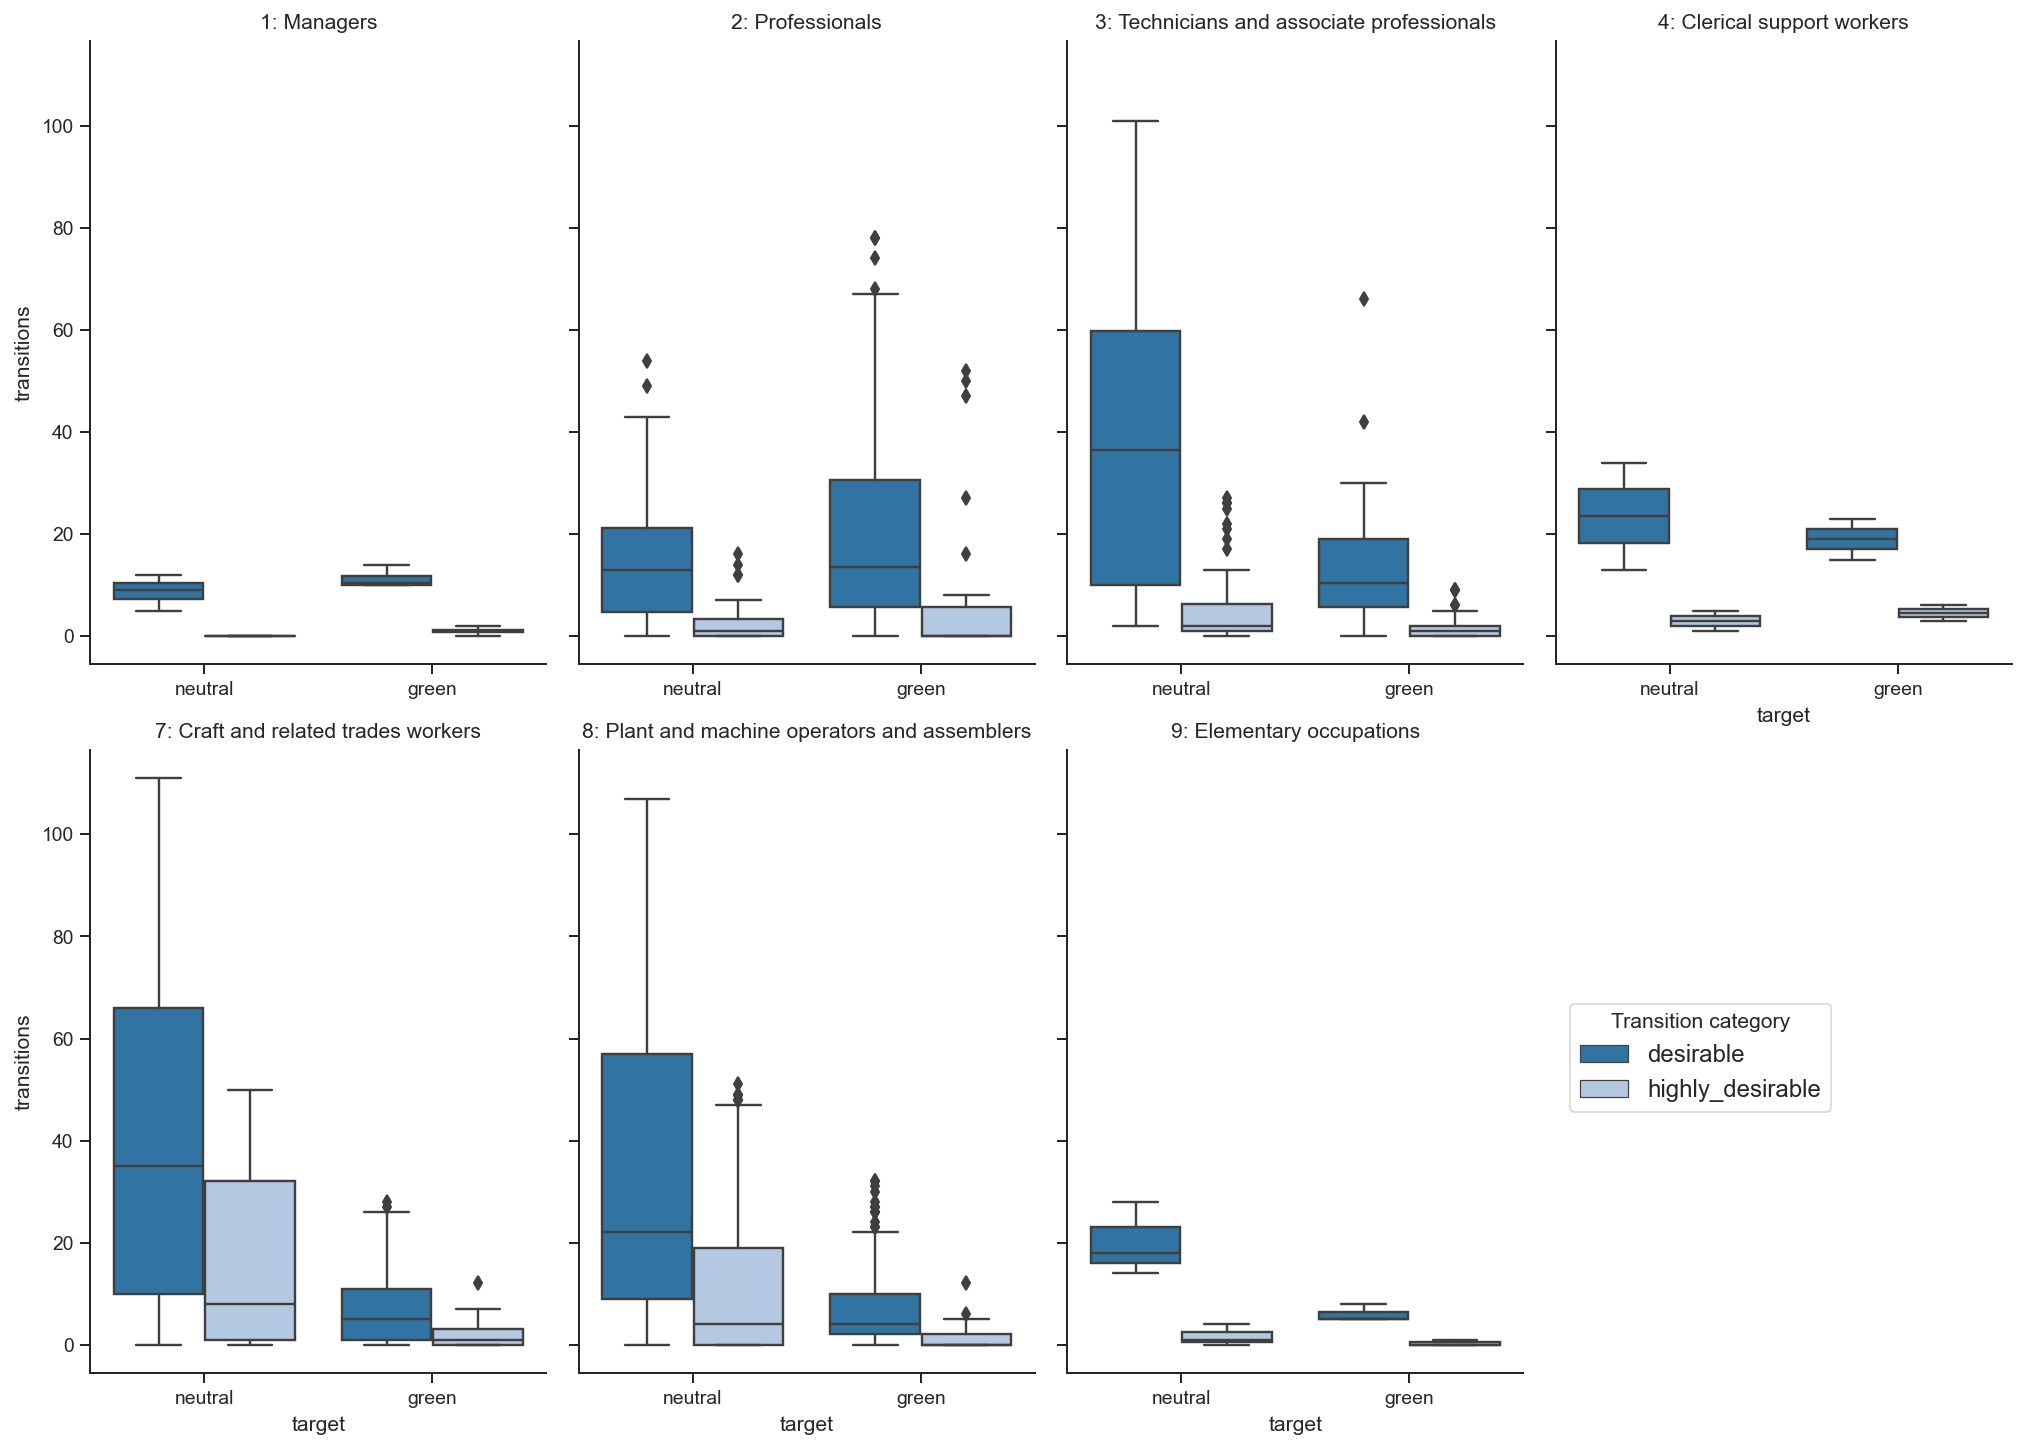

In [120]:
# plot
c = sns.catplot(
    y="transitions",
    x="target",
    hue="category",
    col="isco_level_1",
    col_wrap=4,
    kind="box",
    #order=new_labels[0:4] + new_labels[6:9],
    order=["neutral", "green"],
    palette="tab20",
    #ci=95,
    #capsize=0.05,
    #errwidth=1,
    sharex=False,
    height=5,
    aspect=0.7,
    legend=False,
    data=data
)

for i, ax in enumerate(c.axes):
    ax.set_title(new_labels_short[i])

plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0.4), fontsize=12, title="Transition category")

# plt.savefig(
#     os.path.join(figure_dir, "RQ4", "n_transitions_source_brown_only_by_isco1_reordered.png"),
#     dpi=300,
#     bbox_inches="tight"
# )